## IR Excess Probabilities

---

Trying to calculate the probability of a given star having an infrared excess in the previous file. Suppose there are two samples: white dwarfs with and without IR excesses. These are drawn from the distributions $f_1(x)$ and $f_0(x)$ for IR excess and non-IR excess respectively. Then by Bayes' theorem, we can calculate a posterior: $$P(f_1 | x) = \frac{p(x|f_1)p(f_1)}{p(x|f_1)p(f_1) + p(x|f_0)p(f_0)}$$

Where $x$ are the values of the W1 and W2 deviations from the prior notebook. The prior probabilities $p(f_1)$ and $p(f_0)$ can be determined by figuring out how prevalent IR excesses are over all. In this notebook, I'm gonna try and use some fancy methods to calculate $p(x|f_1)$ and $p(x|f_0)$ in particular.

In [253]:
from astropy.table import Table, join
import pyphot
from pyphot import unit
import sys
sys.path.append('../corv/src')
import corv

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob

from pyvo import registry  # version >=1.4.1 

plt.style.use('stefan.mplstyle')

In [254]:
# Tremblay+2019
dist_catalog = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/MNRAS/482/5222/tablea1.dat')
# Raddi+2022
wd_reference = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/658/A22/table5.dat.gz')

In [255]:
# Morrell+2019
CATALOGUE = "VI/156"
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()
tables_names = list(tables.keys())
# get the first table of the catalogue
first_table_name = tables_names[-1]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
f'select * from "{first_table_name}"',
)
mdwarf_reference = Table.read(tap_records.votable)

In [256]:
mdwarf_reference[0:5]['__Fe_H_']

--
--
--
--
--


In [257]:
teff_counts, teff_bins = np.histogram(10**wd_reference['logTeff'], bins = 250)
teff_counts = teff_counts / sum(teff_counts)

logg_counts, logg_bins = np.histogram(wd_reference['logg'], bins = 200)
logg_counts = logg_counts / sum(logg_counts)

dist_counts, dist_bins = np.histogram(100 / dist_catalog['plx'], bins = 250)
dist_counts = dist_counts / sum(dist_counts)

radius_counts, radius_bins = np.histogram(wd_reference['Radius'], bins = 100)
radius_counts = radius_counts / sum(radius_counts)

# M-Dwarfs:
mdteff_counts, mdteff_bins = np.histogram(mdwarf_reference['Teff'], bins = 100)
mdteff_counts = mdteff_counts / sum(mdteff_counts)

mdlogg_counts, mdlogg_bins = np.histogram(mdwarf_reference['logg'], bins = 100)
mdlogg_counts = mdlogg_counts / sum(mdlogg_counts)

mdr_counts, mdr_bins = np.histogram(mdwarf_reference['Rad'], bins = 100)
mdr_counts = mdr_counts / sum(mdr_counts)

In [258]:
mdwarf_files = glob.glob('data/mdwarf/SPECTRA/*')
teffs = []
loggs = []
logZs = []
CtoOs = []

for file in mdwarf_files:
    split = file.split('_')

    teffs.append(float(split[1]))
    loggs.append(float(split[3]))
    logZs.append(float(split[5]))
    CtoOs.append(float(split[7]))

teffs = sorted(list(set(teffs)))
loggs = sorted(list(set(loggs)))
logZs = sorted(list(set(logZs)))
CtoOs = sorted(list(set(CtoOs)))

In [259]:
c = 3e8

i = 0
if (logZs[i] >= 0):
    baseline = 'data/mdwarf/SPECTRA/Teff_{}_logg_{}_logZ_+{}_CtoO_{}_spectra.txt'.format(teffs[i], loggs[i], logZs[i], CtoOs[i])
else:
    baseline = 'data/mdwarf/SPECTRA/Teff_{}_logg_{}_logZ_{}_CtoO_{}_spectra.txt'.format(teffs[i], loggs[i], logZs[i], CtoOs[i])
f = open(baseline).read().splitlines()[1:]
f = np.array([np.fromstring(f[i], dtype=float, sep=" ") for i in range(len(f))]).T

f[0] = f[0] * 10000 # micron to angstrom
f[1] = f[1] * ((f[0]*1e-10)**2 / c) # W/m^2/m to W/m^2/Hz
f[1] = 2.99792458e21 * f[1] / f[0]**2 # W/m^2/Hz to  erg/cm^2/s/A

base_wavl = f[0]

In [260]:
from scipy.interpolate import RegularGridInterpolator

data = np.zeros((len(teffs), len(loggs), len(logZs), len(CtoOs), len(base_wavl)))

for i in tqdm(range(len(teffs))):
    for j in range(len(loggs)):
        for k in range(len(logZs)):
            for n in range(len(CtoOs)):
                try:
                    if (logZs[k] >= 0):
                        baseline = 'data/mdwarf/SPECTRA/Teff_{}_logg_{}_logZ_+{}_CtoO_{}_spectra.txt'.format(teffs[i], loggs[j], logZs[k], CtoOs[n])
                    else:
                        baseline = 'data/mdwarf/SPECTRA/Teff_{}_logg_{}_logZ_{}_CtoO_{}_spectra.txt'.format(teffs[i], loggs[j], logZs[k], CtoOs[n])

                    f = open(baseline).read().splitlines()[1:]
                    f = np.array([np.fromstring(f[m], dtype=float, sep=" ") for m in range(len(f))]).T
                except FileNotFoundError:
                    print(baseline)
                
                f[0] = f[0] * 10000 # micron to angstrom
                f[1] = f[1] * ((f[0]*1e-10)**2 / c) # W/m^2/m to W/m^2/Hz
                f[1] = 2.99792458e21 * f[1] / f[0]**2 # W/m^2/Hz to  erg/cm^2/s/A
                wavl = np.interp(base_wavl, f[0], f[1])

                data[i,j,k,n] = wavl

mdwarf_fl = RegularGridInterpolator((teffs, loggs, logZs, CtoOs), data)

100%|██████████| 21/21 [01:42<00:00,  4.90s/it]


In [275]:
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support

def generate_state_vector():
    wd_teff = np.random.choice(teff_bins[1:], p=teff_counts)
    while (2000 > wd_teff) or (wd_teff > 130000):
        wd_teff = np.random.choice(teff_bins[1:], p=teff_counts)
    wd_logg = np.random.choice(logg_bins[1:], p=logg_counts)
    while (7 > wd_logg) or (wd_logg > 9):
        wd_logg = np.random.choice(logg_bins[1:], p=logg_counts)

    wd_dist = np.random.choice(dist_bins[1:], p=dist_counts)
    wd_radius = np.random.choice(radius_bins[1:], p=radius_counts)
    
    p = np.random.uniform(0, 1)

    disk_teff = np.abs(np.random.normal(2000, 750))
    disk_scale = np.random.uniform(0,2)

    ms_teff = np.random.choice(mdteff_bins[1:], p=mdteff_counts)
    while (2000 > ms_teff) or (ms_teff > 4000):
        ms_teff = np.random.choice(mdteff_bins[1:], p=mdteff_counts)
    ms_logg = np.random.choice(mdlogg_bins[1:], p=mdlogg_counts)
    while (4.25 > ms_logg) or (ms_logg > 5.5):
        ms_logg = np.random.choice(mdlogg_bins[1:], p=mdlogg_counts)

    ms_logZ = np.random.uniform(min(logZs), max(logZs))
    ms_CtoO = np.random.uniform(min(CtoOs), max(CtoOs))
    ms_radius = np.random.choice(mdr_bins[1:], p=mdr_counts)
    
    return [wd_teff, wd_logg, wd_dist, wd_radius, disk_teff, disk_scale, ms_teff, ms_logg, ms_logZ, ms_CtoO, ms_radius, p]

In [276]:
import lmfit

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]
base_wavl_wd, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

In [277]:
def blackbody(teff): #, radius, distance):
    c = 2.99e8
    bb = BlackBody(temperature=teff*u.K, scale = 1* u.erg / (u.cm ** 2 * u.s * u.AA * u.sr))
    si = bb(base_wavl_wd * u.AA).value * 1e-4
            
    return si# / (2 * np.pi)  

def generate_observation(theta, disk_fraction = 0.07, cv_fraction = 0.2):
    pc_to_m = 3.086775e16
    radius_sun = 6.957e8
    
    spec = tremblay((theta[0], theta[1])) * ((theta[3] * radius_sun) / (theta[2] * pc_to_m))**2
    
    if (0 < theta[-1] < disk_fraction):
        spec += blackbody(theta[4]) * ((theta[5] * radius_sun) / (theta[2] * pc_to_m))**2
    if (disk_fraction < theta[-1] < disk_fraction + cv_fraction):
        spec += np.interp(base_wavl_wd, base_wavl, mdwarf_fl((theta[6], theta[7], theta[8], theta[9])))\
                     * ((theta[10] * radius_sun) / (theta[2] * pc_to_m))**2
        
    fluxes = [filters[j].get_flux(base_wavl_wd * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = np.array([-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag + np.random.normal(scale = 0.03) for j in range(len(filters))])
    
    mags[0] += np.random.normal(0, 0.03)
    mags[1] += np.random.normal(0, 0.03)
    mags[2] += np.random.normal(0, 0.03)
    mags[3] += np.random.normal(0, 0.05)
    mags[4] += np.random.normal(0, 0.05)
    
    return mags - 5 * np.log10(theta[2]) + 5

In [278]:
theta = [10000, 8, 100, 0.06, 0.2, 1, 1, 253]
generate_observation(theta)

array([11.52464178, 11.63596076, 11.51341248, 11.49688779, 11.55326995])

In [279]:
theta = generate_state_vector()
mags = generate_observation(theta)

In [281]:
n = 1000

g = []
bp = []
rp = []
w1 = []
w2 = []

state = []
obs = []

for i in tqdm(range(n)):
    theta = generate_state_vector()
    try:
        mags = generate_observation(theta)
    except:
        print(theta)

    state.append(np.array(theta))
    obs.append(np.array(mags))
    
state = np.array(state)
obs = np.array(obs).T

  7%|▋         | 71/1000 [00:18<03:23,  4.56it/s]

[10826.841504311235, 7.4107, 60.08830769923857, 0.0131, -66.60314504660255, 1.1665956084423528, 3560.0, 5.005, 0.5543373062812023, 0.3346442522777813, 0.30031228697155177, 0.03293250892409949]


 13%|█▎        | 134/1000 [00:30<02:14,  6.44it/s]

[12856.24848767282, 7.111, 38.580148599386504, 0.0131, -233.120431566128, 0.28762744350592184, 3274.0, 5.41, -0.3478085240977353, 0.6804004888069402, 0.4586184476988213, 0.0694486266351726]


 51%|█████     | 509/1000 [01:57<01:14,  6.61it/s]

[31881.93895668768, 7.8325000000000005, 15.023593394786621, 0.014000000000000002, -113.59978435792073, 1.5752711317323853, 3692.0, 4.915, 0.6717429061953106, 0.3005677863732346, 0.49515063863588354, 0.05911199404275291]


100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


In [282]:
base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

bp_rp = []
rp_w1 = []
rp_w2 = []

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

logg = 8
teffs = np.linspace(5000, 120000, 100)

for i in tqdm(range(len(teffs))):
    spec = tremblay((teffs[i], logg))
    
    fluxes = [filters[j].get_flux(base_wavl * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = [-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag for j in range(len(filters))]
    
    bp_rp.append(mags[1] - mags[2])
    rp_w1.append(mags[2] - mags[3])
    rp_w2.append(mags[2] - mags[4])
    
bp_rp = list(reversed(bp_rp))
rp_w1 = list(reversed(rp_w1))
rp_w2 = list(reversed(rp_w2))

w1_diffs = (obs[2] - obs[3]) - np.interp((obs[1] - obs[2]), bp_rp, rp_w1)
w2_diffs = (obs[2] - obs[4]) - np.interp((obs[1] - obs[2]), bp_rp, rp_w2)


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


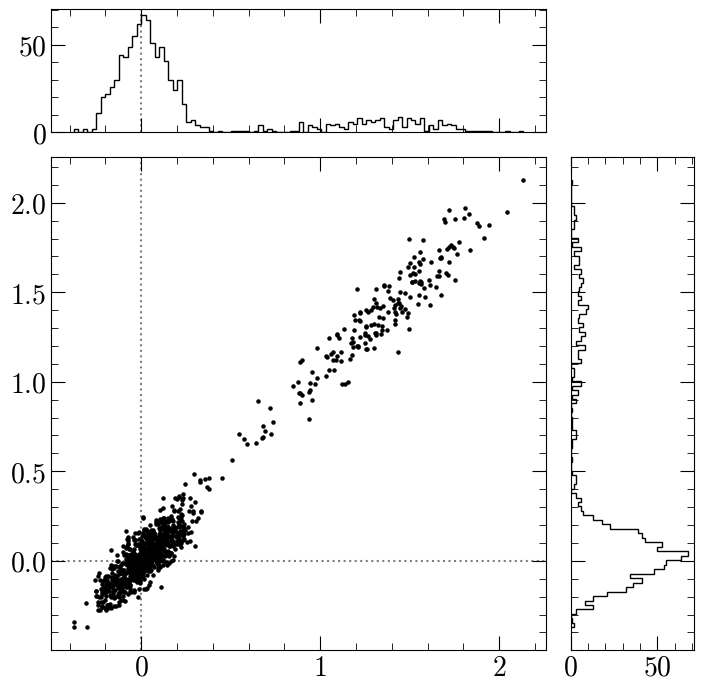

In [283]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c = 'k', s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')

    # now determine nice limits by hand:
    binwidth = 0.25
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')

fig = plt.figure(layout='constrained')

ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

scatter_hist(w1_diffs, w2_diffs, ax, ax_histx, ax_histy)

plt.show()

Text(0.5, 0, 'RP - W2 Deviation')

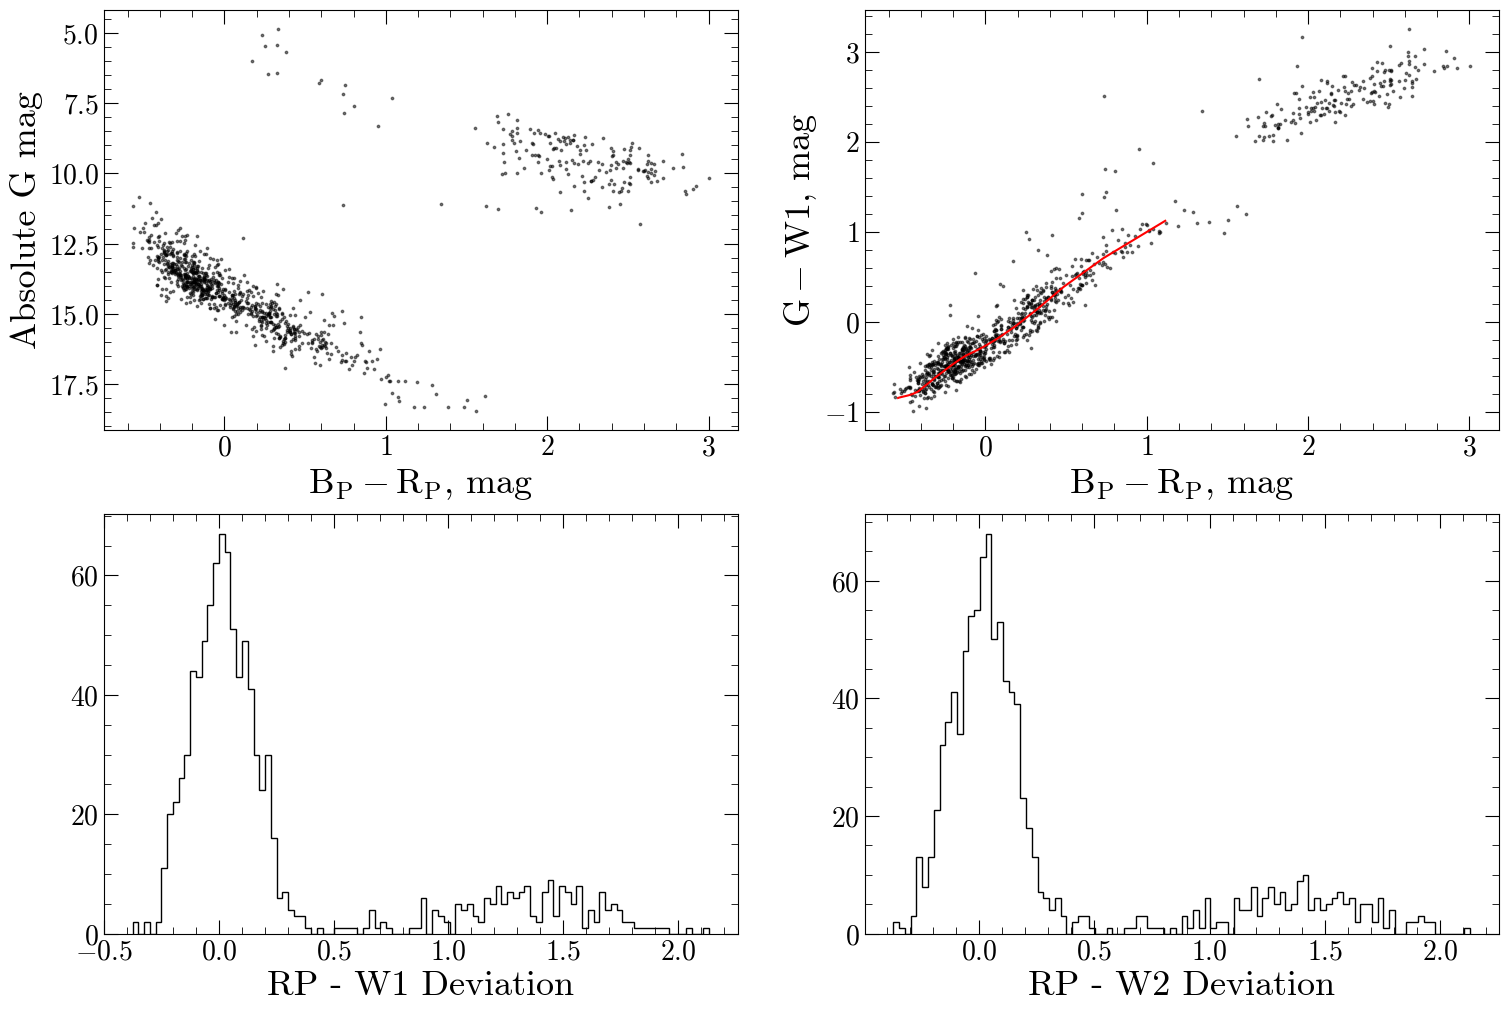

In [284]:
plt.figure(figsize = (18,12))

plt.subplot(2,2,1)
plt.scatter(obs[1] - obs[2], obs[0], s = 3, c = 'k', alpha = 0.5)

plt.xlabel('$B_P - R_P$, mag')
plt.ylabel('Absolute G mag')

plt.gca().invert_yaxis()

plt.subplot(2,2,2)
plt.scatter(obs[1] - obs[2], obs[2] - obs[3], s = 3, c = 'k', alpha = 0.5)
plt.plot(bp_rp, rp_w1, c='red')

plt.xlabel('$B_P - R_P$, mag')
plt.ylabel('$G - W1$, mag')

plt.subplot(2,2,3)
plt.hist(w1_diffs, color = 'k', histtype = 'step', bins = 100)

plt.xlabel('RP - W1 Deviation')

plt.subplot(2,2,4)
plt.hist(w2_diffs, color = 'k', histtype = 'step', bins = 100)

plt.xlabel('RP - W2 Deviation')